# Regression

Regression attempts to fit a function model to training data. Let's create a data set from a function, here $f = 3x^3 - 2x$, and add some Gaussian noise with standard deviation `sigma`:

In [1]:
import numpy as np

def generate_data(X, f=lambda x: 3*x**3 - 2*x, sigma=0.1):
    y = f(X) + np.random.normal(scale=sigma, size=X.shape)
    return y

X = np.linspace(-1,1,9)
y = generate_data(X)

X_test = np.linspace(-1, 1, 41)
y_test = generate_data(X_test, sigma=0.0)

### Visualize data

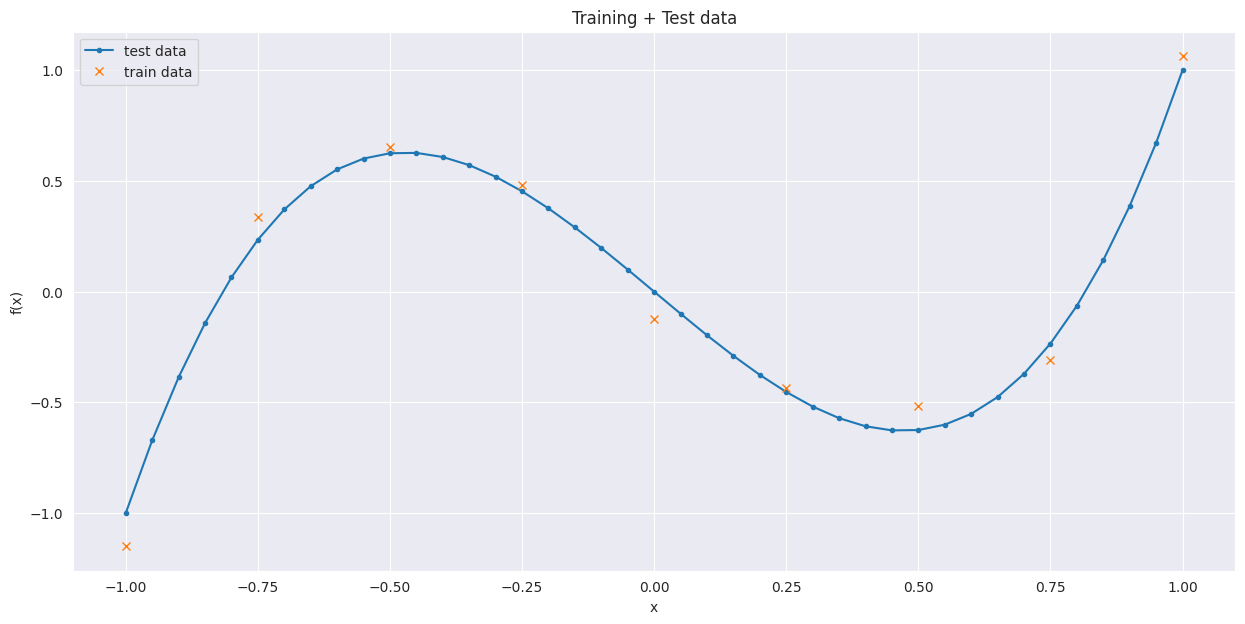

In [2]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('darkgrid')

plt.figure(figsize=(15, 7))
plt.title("Training + Test data")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(X_test, y_test, ".-", label="test data")
plt.plot(X, y, 'x', label="train data")
plt.legend()
plt.show()

## Task 1: Polynomial function fitting

Augment the following code snippet to actually compute the nonlinear regression given the first $1..M$ training data points and considering a polynomial model of degree $P \in \{0..8\}$.  
What do you expect as optimal parameter values $w_0$ to $w_3$ for a polynomial model of degree $P=3$?

In [5]:
class Regression:
    def __init__(self, alpha=0.0):
        self.w = np.zeros(0)
        self.alpha = alpha

    def predict(self, X):  # apply prediction model to data X
        X = np.hstack((np.ones((X.shape[0], 1)), X)) 
        return np.dot(X, self.w) 

    def fit(self, X, y):  # TODO: compute optimal weights for training data (X,y)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        pseudo_inverse = np.linalg.pinv(np.dot(X.T, X))
        #self.w = np.zeros(X.shape[1])
        self.w = np.dot(np.dot(pseudo_inverse, X.T), y)

In [6]:
from matplotlib import pyplot as plt
from ipywidgets import interact

# [@interact] makes the following function (update) interactive, with sliders for M and P
@interact(M=(1, len(X)), P=(0, 8))
def update(M=len(X), P=3):
    def design_matrix(X):  # compute polynomial features
        return np.power(np.transpose([X]), range(0, P+1))
    
    # train regression model
    reg = Regression()
    reg.fit(design_matrix(X[0:M]), y[0:M])  # fit the first M training points only
    print('w: ', reg.w)

    plt.figure(42, figsize=(15,7))
    plt.plot(X_test, y_test, '.-', label="test data")  # plot ground truth of test data
    plt.plot(X_test, reg.predict(design_matrix(X_test)), 'r-', label="prediction")  # plot model prediction on test data
    plt.scatter(X[0:M], y[0:M], marker='x', label="train data") # plot training data
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=9, description='M', max=9, min=1), IntSlider(value=3, description='P', m…

What do you expect as optimal parameter values  𝑤0  to  𝑤3  for a polynomial model of degree  𝑃=3 ? - for y = 3x^2 -2x , to find optimal parameters, we can simply match the coefficients in polynomial equation: w_0 (constant term) = 0, w_1(linear) = -2, w_2(quadratic) = 0 and w_3(cubic) = 3. As we can also observe in above output values of w. (reg.w includes bias term as first value, followed by the 4 coefficients which are similar to optimal coefficients).

## Task 2

Explain, what is learned in the following situations:

1. $M=9$, $P=0$
2. $M=4$, $P=3$
3. $M=9$, $P=8$

1. When M=9, we are using only the first 9 data points to train the model. With P=0, the polynomial model is of degree 0, which means it's a constant model. In this case, the model will learn only a constant value (the bias term) that minimizes the mean squared error for the first 9 data points. This model won't capture any variation in the data and it's a poor fit.

2. When M =4 and P = 3 which means it can represent a cubic function. In this case, the model will try to learn the coefficients of a cubic function that best fits the first 4 data points. as we are using small data set, it might overfit and may not generalize well over remaining data.

3. When M= 9 and P =8, polynomial model of degree 8. In thsi case, model will try to learn the coefficients of 8th degree polynomial that best fits the first 9 data paoints. But here model complexity > training data points used, model might overfit and capture noise. This might give rise to poor genralization over remaining data.

## Task 3: Ridge Regression

To improve the smoothness of the learned function model, we can use Ridge regression, which adds a regularization term to our cost function:

${\cal L} = \frac{1}{M} \|\hat{\mathbf y} - \mathbf y\|^2 + \lambda \|\mathbf w\|^2$

Show and verify step by step that the minimization of this loss functions yields the learning rule of Ridge regression:

$\mathbf w^* = (\mathbf X^t \mathbf X + \lambda \mathbf 1)^{-1} \mathbf X^t \mathbf y$

_Hint_: See [_The Matrix Cookbook_ (Petersen and Pedersen, 2012)](http://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf), for derivatives (section 2.4), norms (section 10.3) and other identities of vectors and matrices.

Extend your implementation to perform Ridge regression.  
Introduce $\lambda$ as a new parameter `alpha` to your `update` function and determine a suitable value for the case $P=8, M=9$ from task 2.  
Explain what happens for very large and very small values of $\lambda$.

First we need to minimize the loss function:

min{ (^y - w^Tx)^T(^y - w^Tx) + lambda w^Tw}

Since:

d/dw (^y - w^Tx)^T(^y - w^Tx) = -2x^T(^y - w^Tx)

and:

d lambda w^Tw / dw = 2 lambda w

we get x^t^y = x^Txw+lambda w

We can now isolate w and get the result:

w=(x^Tx+lambda I)^-1 x^T^y

In [7]:
class RidgeRegression:
    def __init__(self, alpha=0.0):
        self.w = np.zeros(0)
        self.alpha = alpha

    def predict(self, X):  # apply prediction model to data X
        X = np.hstack((np.ones((X.shape[0], 1)), X)) 
        return np.dot(X, self.w) 

    def fit(self, X, y, alpha):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        pseudo_inverse = np.linalg.pinv(np.dot(X.T, X) + (np.identity(X.shape[1]) * alpha))
        self.w = np.dot(np.dot(pseudo_inverse, X.T), y)

In [8]:
from matplotlib import pyplot as plt
from ipywidgets import interact

# [@interact] makes the following function (update) interactive, with sliders for M and P
@interact(M=(1, len(X)), P=(0, 8), alpha=(0., 1.0, 0.01))
def update(M=len(X), P=8, alpha=0.1):
    def design_matrix(X):  # compute polynomial features
        return np.power(np.transpose([X]), range(0, P+1))
    
    # train regression model
    reg = RidgeRegression()
    reg.fit(design_matrix(X[0:M]), y[0:M], alpha)  # fit the first M training points only
    print('w: ', reg.w)

    plt.figure(42, figsize=(15,7))
    plt.plot(X_test, y_test, '.-', label="test data")  # plot ground truth of test data
    plt.plot(X_test, reg.predict(design_matrix(X_test)), 'r-', label="prediction")  # plot model prediction on test data
    plt.scatter(X[0:M], y[0:M], marker='x', label="train data") # plot training data
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=9, description='M', max=9, min=1), IntSlider(value=8, description='P', m…

If lambda is too small we encourage overfitting since the L2 regularisation has a very small factor. Is lambda too large we observe that we get an result that is quite far off the test data, in other words we get the inverse problem of overfitting.

## Task 4: LASSO

Instead of using the L2 norm, i.e. the _squared_ Euclidean norm $\|\mathbf w\|_2^2 = \sum w_i^2$, one can also use the L1 norm, i.e. $\|\mathbf w\|_1 = \sum |w_i|$, as a regularization term.  
This results in LASSO regression (_least absolute shrinkage and selection operator_).

1. Replace your `Regression` instance with the [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso) regressor from [scikit-learn](https://scikit-learn.org):  
   ```python
   from sklearn.linear_model import Lasso
   ```  
   Compare the resulting weight vectors with those from Ridge regression. What do you observe? When comparing the weights of the Rdige regression to the weights of the Lasso regression, we oberserve two things. 
  1. Ridge regression produces larger weights compared to Lasso regression. This is because Ridge regression shrinks the coefficients towards zero by adding a penalty term to the sum of squared weights, which results in a smaller but non-zero value. Therefore, the weights in Ridge regression are generally less sparse than those in Lasso regression.

  2. Lasso regression, on the other hand, encourages sparsity in the weights by using a penalty term that involves the absolute values of the weights. As a result, Lasso regression tends to produce more sparse weights, with many coefficients being exactly zero. see that Lasso forces most othe weights that are not 

2. Determine and sketch the derivatives of both norms w.r.t. $\mathbf w$. 
  
  The derivative of the $L_2$ norm w.r.t to $\mathbf{w}$ is determined as follows: $$\frac{\partial}{\partial w_j}\|\mathbf w\|^2 =\frac{\partial}{\partial w_j}\sum_{k=1}^n w_k^2=\sum_{k=1}^n \underbrace{\frac{\partial}{\partial w_j}w_k^2}_{\substack{=0, \ \text{ if } j \neq k,\\=2w_j, \ \text{ else }}}= 2w_j$$

  The derivative of the $L_1$ norm w.r.t to $\mathbf{w}$ does not exist, since L1 norm is a nonsmooth function. To sketch the derivatives, we need to consider the behavior of the function for positive and negative values of $w_i$. The function is non-continuous at $w_i = 0$, where it changes sign. The derivative is 1 for $w_i > 0$ and -1 for $w_i < 0$. Therefore we can say that: 

The derivative of the L1 norm is:

$$
\frac{\partial}{\partial \mathbf{w}} ||\mathbf{w}||_1 = \frac{\partial}{\partial \mathbf{w}} \sum_{i=1}^n |w_i| = \text{sign}(\mathbf{w})
$$

where $\text{sign}(\mathbf{w})$ denotes the element-wise sign of $\mathbf{w}$.

  What are the advantages and disadvantages of both regularization terms?

L1 Regularization:

Advantages:
- Encourages sparsity: L1 regularization promotes sparse solutions by setting some of the coefficients to exactly zero. This can be useful in feature selection, where we want to identify the most important features for prediction.
- Works well with high-dimensional data: L1 regularization can handle datasets with many features and can identify the most important ones.
- Increases model interpretability: The sparse solutions resulting from L1 regularization can make the model easier to interpret, as only the most important features are used.

Disadvantages:
- Non-differentiable: L1 regularization is non-differentiable at zero, which can make it difficult to optimize.
- Tends to shrink coefficients towards zero: While L1 regularization can encourage sparsity, it can also shrink coefficients towards zero, which can lead to underfitting if the regularization parameter is too large.

L2 Regularization:

Advantages:
- Encourages small but non-zero coefficients: L2 regularization shrinks the coefficients towards zero, but not to exactly zero, which can help prevent overfitting without reducing the number of features used.
- Differentiable: L2 regularization is differentiable, making it easier to optimize.
- Smooths model coefficients: L2 regularization can smooth the weights, which can make the model more robust to small changes in the input data.

Disadvantages:
- May not lead to sparsity: L2 regularization generally does not lead to sparse solutions, which can make feature selection more difficult.
- Can amplify the impact of outliers: L2 regularization treats all errors equally, which can make it sensitive to outliers in the data.

In [10]:
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
from ipywidgets import interact

# [@interact] makes the following function (update) interactive, with sliders for M and P
@interact(M=(1, len(X)), P=(0, 8), alpha=(0., 1.0, 0.01))
def update(M=len(X), P=8, alpha=0.1):
    def design_matrix(X):  # compute polynomial features
        return np.power(np.transpose([X]), range(0, P+1))
    
    # train regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(design_matrix(X[0:M]), y[0:M], alpha)  # fit the first M training points only
    print('w: ', lasso.coef_)

    plt.figure(42, figsize=(15,7))
    plt.plot(X_test, y_test, '.-', label="test data")  # plot ground truth of test data
    plt.plot(X_test, lasso.predict(design_matrix(X_test)), 'r-', label="prediction")  # plot model prediction on test data
    plt.scatter(X[0:M], y[0:M], marker='x', label="train data") # plot training data
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=9, description='M', max=9, min=1), IntSlider(value=8, description='P', m…